# Creating the Model Grid

This notebook is used to generate and visualize the grids that my model will use. First, import the necessary packages to create the model grid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

## An's Model of Ha Long Bay

The grid for An's model will be located on the northern coast of Vietnam covering  $20.7^{\circ}-20.9^{\circ}N$, $107^{\circ}-107.2^{\circ}E$ . The grid spacing will be $1/800^{\circ}$ in the zonal (east-west) direction and $1/800^{\circ}$ in the meridional (north-south) direction, covering a grid of 161 rows and 161 columns. 

In the data file for my model, I will specifiy the following parameters in the `PARM04` namelist in the `data` file:

```
usingSphericalPolarGrid=.TRUE.,
delX=161*0.00125,
delY=161*0.00125,
xgOrigin=107.0,
ygOrigin=20.7,
```

This grid can be recreated in Python as follows:

In [2]:
# define the parameters that will be used in the data file
delX = 1/800
delY = 1/800
xgOrigin = 107.0
ygOrigin = 20.7
n_rows = 161
n_cols = 161

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

### Visualizing the Grid
The grids above can be visualized as follows:

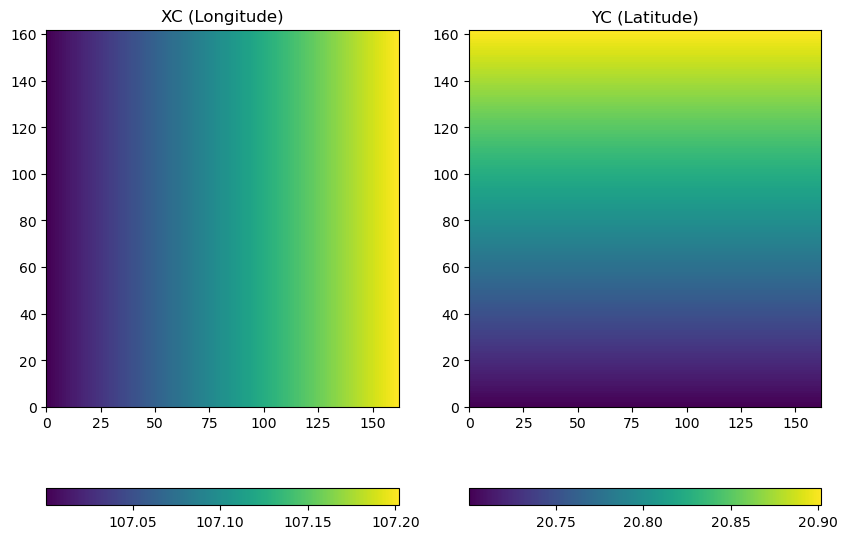

In [3]:
# make a plot of XC and YC
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('XC (Longitude)')

plt.subplot(1,2,2)
C = plt.pcolormesh(YC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC (Latitude)')

plt.show()

### Visualizing the Grid on a Map with Cartopy
Ha Long Bay is located in North Vietnam. To understand the area that we are studying, the below visualization is provided given the model grid.

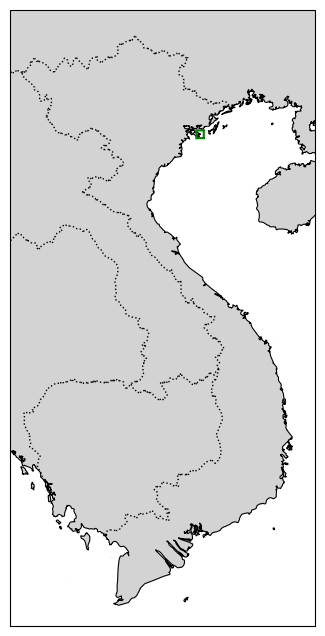

In [4]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Orthographic(105.0,16.0))

ax.plot(XC[:,0], YC[:,0], 'g-', linewidth=1.5, transform=ccrs.PlateCarree())
ax.plot(XC[:,-1], YC[:,-1], 'g-', linewidth=1.5, transform=ccrs.PlateCarree())
ax.plot(XC[0,:], YC[0,:], 'g-', linewidth=1.5, transform=ccrs.PlateCarree())
ax.plot(XC[-1,:], YC[-1,:], 'g-', linewidth=1.5, transform=ccrs.PlateCarree())

ax.coastlines(resolution='10m', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, facecolor='lightgray')
ax.add_feature(cartopy.feature.OCEAN, facecolor='white')

ax.set_extent([102, 110, 8, 24], crs=ccrs.PlateCarree()) 

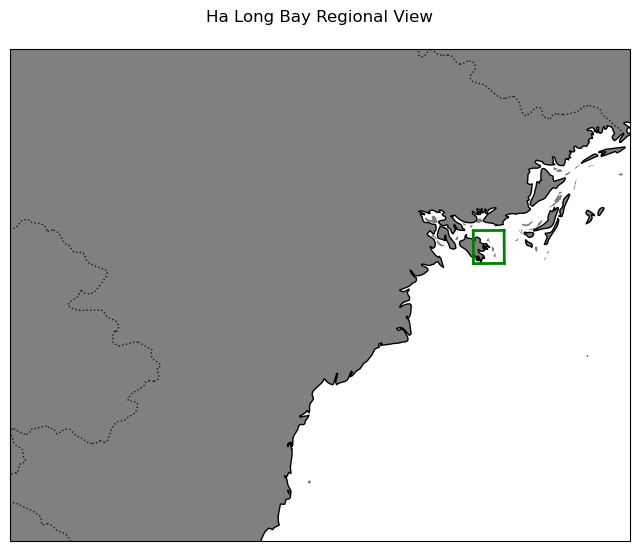

In [11]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=106.0, central_latitude=20.5))

ax.plot(XC[:,0], YC[:,0], 'g-', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(XC[:,-1], YC[:,-1], 'g-', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(XC[0,:], YC[0,:], 'g-', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(XC[-1,:], YC[-1,:], 'g-', linewidth=2, transform=ccrs.PlateCarree())

ax.set_extent([104, 108, 19, 22], crs=ccrs.PlateCarree())  # Perfect mid-range

ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=0.8)
ax.add_feature(cartopy.feature.LAND, facecolor='gray')
ax.add_feature(cartopy.feature.OCEAN, facecolor='white')

plt.title("Ha Long Bay Regional View", pad=20)
plt.show()

### Visualizing the Grid Spacing
The model grid is defined in terms of units in longitude and latitude although it is useful to quantify the grid spacing in terms of more familiar units, such as meters. The following `great_circle_distance` function can be used to quantify this distance:

In [6]:
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

Then, loop through the points to generate inter-point distances in the horizontal (`dXC`) and vertical (`dYC`) directions:

In [7]:
dXC = np.zeros((np.shape(XC)[0], np.shape(XC)[1]-1))
for row in range(np.shape(XC)[0]):
    for col in range(np.shape(XC)[1]-1):
        dXC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row,col+1], YC[row,col+1])

dYC = np.zeros((np.shape(YC)[0]-1, np.shape(YC)[1]))
for row in range(np.shape(XC)[0]-1):
    for col in range(np.shape(XC)[1]):
        dYC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row+1,col], YC[row+1,col])

Finally, make a plot of the inter-point distances:

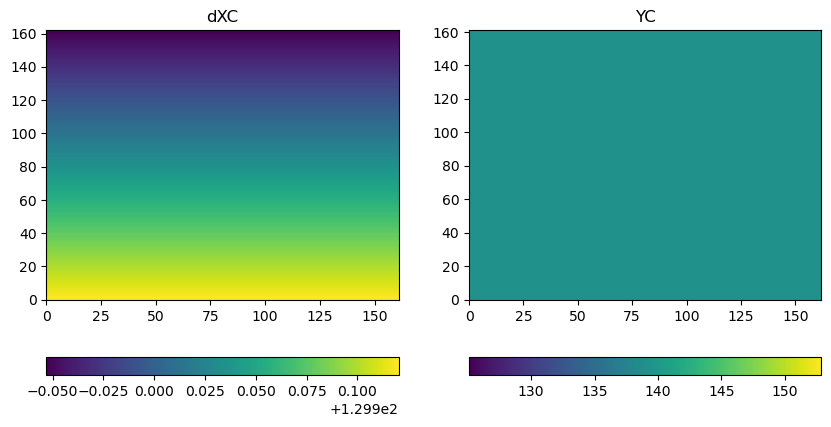

In [8]:
# make a plot of XC and YC
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(dXC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('dXC')

plt.subplot(1,2,2)
C = plt.pcolormesh(dYC.round(3))
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC')

plt.show()

As we can see the grid has a resolution of about 130 km, although there is a north-south gradient in horizontal distances (in other words, points further north are closer together). 